In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib
import pickle
from matplotlib import cm
from tqdm import tqdm
import scipy.stats as stats
import seaborn as sns

In [2]:
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True) # Turn off tqdm for a clean display 

In [3]:
import os
os.chdir("..")
plt.style.use('plot_style.txt')
fig_save_path = os.path.join(os.path.abspath(os.curdir), "Simulation", 'figures')

In [4]:
import VPSModeling.Network as net

In [5]:
from matplotlib import cycler
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])


plt.rc('axes',prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid') # '#E6E6E6
plt.rc('xtick', direction='out', color='black')
plt.rc('ytick', direction='out', color='black')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

In [6]:
s1=5.1667 / 1.0
s2=5.1667 / 1.5
a_scale=100
pltx_scale=1000

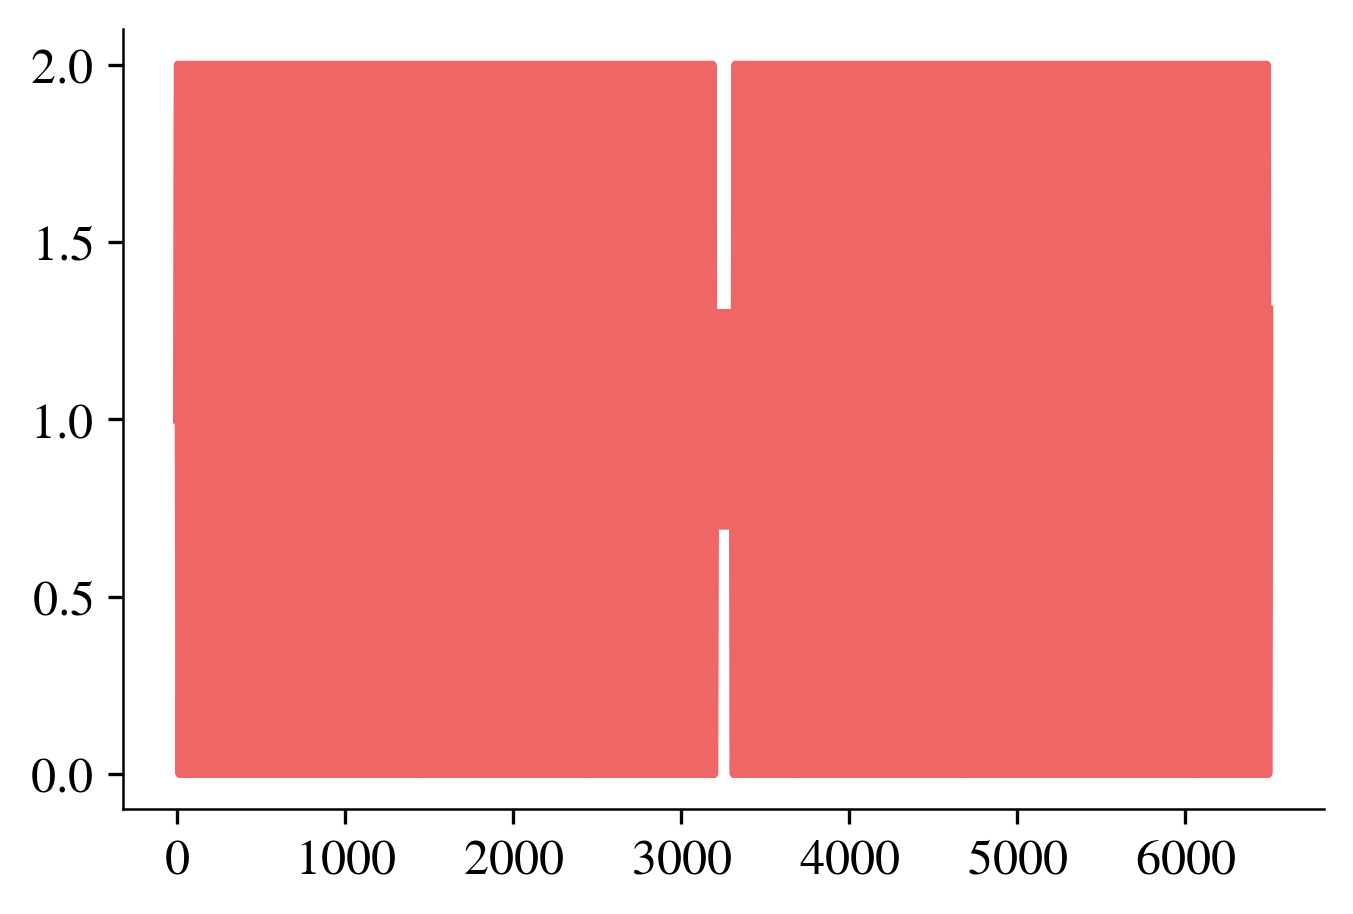

In [7]:
fig, ax = plt.subplots(figsize=(s1, s2))

iscale = 2 
input_scale=8*iscale
I_CC = np.zeros(600*input_scale)
# sampling rate
sr = 100.0
# sampling interval
ts = 1.0/sr
t = np.arange(0,2*input_scale,ts)

freqx=5
freq = freqx   
y = np.sin(2*np.pi*freq*t)+1

I_CC[0:int(2*input_scale*sr)] = y 


# sampling rate
shift= 20
sr_2 = 100.0+shift
ts_2 = 1.0/sr_2
t2 = np.arange(0,1,ts_2)
freq = freqx
y = 0.3*np.sin(2*(np.pi)*freq*t2)+1


I_CC[int(2*input_scale*sr):int((2*input_scale+1)*sr+shift)] = y 

freq = freqx  
y = np.sin(2*(np.pi)*freq*t)+1

I_CC[int((2*input_scale+1)*sr+shift-12):int((4*input_scale+1)*sr+shift-12)] = 2-y



plt.plot(np.arange(0,4*input_scale+1,ts)*int(sr),I_CC[0:int((4*input_scale+1)*sr)])


In [8]:
pixel_ed =int((4*input_scale+1)*sr+shift-12)

In [9]:
mark_pos= int(2*input_scale*sr)


In [10]:
def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

In [11]:
X = normalize(
    I_CC[0:int((4*input_scale+1)*sr+shift-12)],
    {'actual': {'lower': 0, 'upper': 2}, 'desired': {'lower': 0, 'upper': 255}}
) 

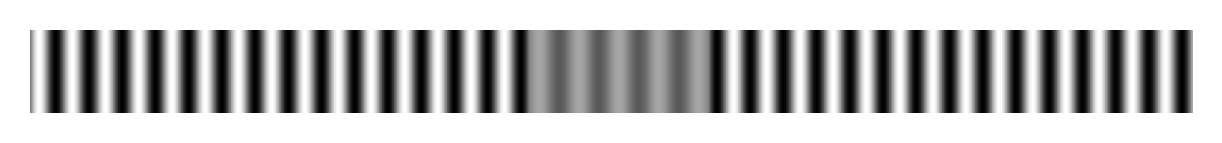

In [12]:
X_2D = np.zeros((50,int((4*input_scale+1)*sr+shift-12)))

for i in range(50):
    X_2D[i,:] = np.array(X) 

plt.figure(figsize=(5, 3))
plt.axis('off')
# plt.imshow(X_2D[:,int(1000*iscale*1.3):pixel_ed-int(1000*iscale*1.3)],cmap='gray')
plt.imshow(X_2D[:,mark_pos-300:mark_pos+50+350 ],cmap='gray')


In [13]:
1000*iscale*1.3

2600.0

(2900.0, 3600.0)

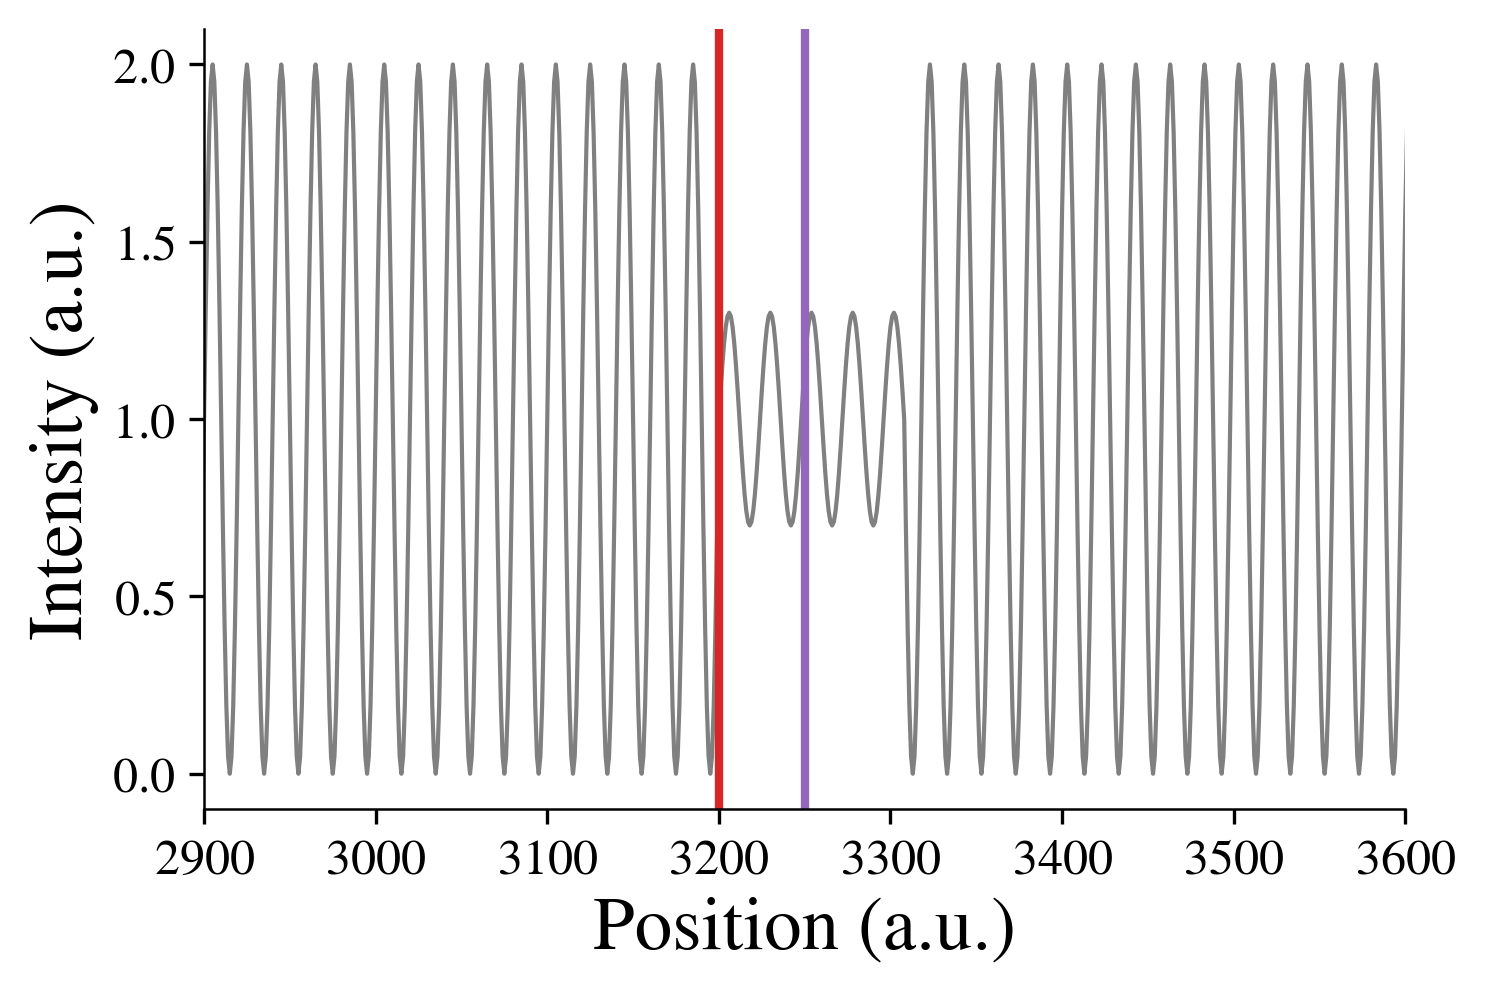

In [14]:
plt_scale=1
plt.figure(figsize=(s1, s2))
plt.plot((np.arange(0,(4*input_scale+1)/plt_scale,ts/plt_scale)*int(sr)),I_CC[0:int((4*input_scale+1)*sr)],linewidth=1
        ,color='grey')
# plt.axvline(x=(mark_pos-300)/1000,color='tab:blue')
plt.axvline(x=(mark_pos+50)/plt_scale,color='tab:purple')
plt.axvline(x=(mark_pos+0)/plt_scale,color='tab:red')
plt.xlabel('Position (a.u.)')
plt.ylabel('Intensity (a.u.)')
# plt.xlim([1000*iscale*1.3/1000,(pixel_ed -1000*iscale*1.3)/1000])
(mark_pos-300)/plt_scale
plt.xlim((mark_pos-300)/plt_scale, (mark_pos+50+350)/plt_scale)

In [15]:
from tqdm import tqdm

[-82.  -81.9 -81.8 ...  81.8  81.9  82. ]
[-165.  -164.9 -164.8 ...  164.8  164.9  165. ]


<Figure size 1550.01x1033.34 with 0 Axes>

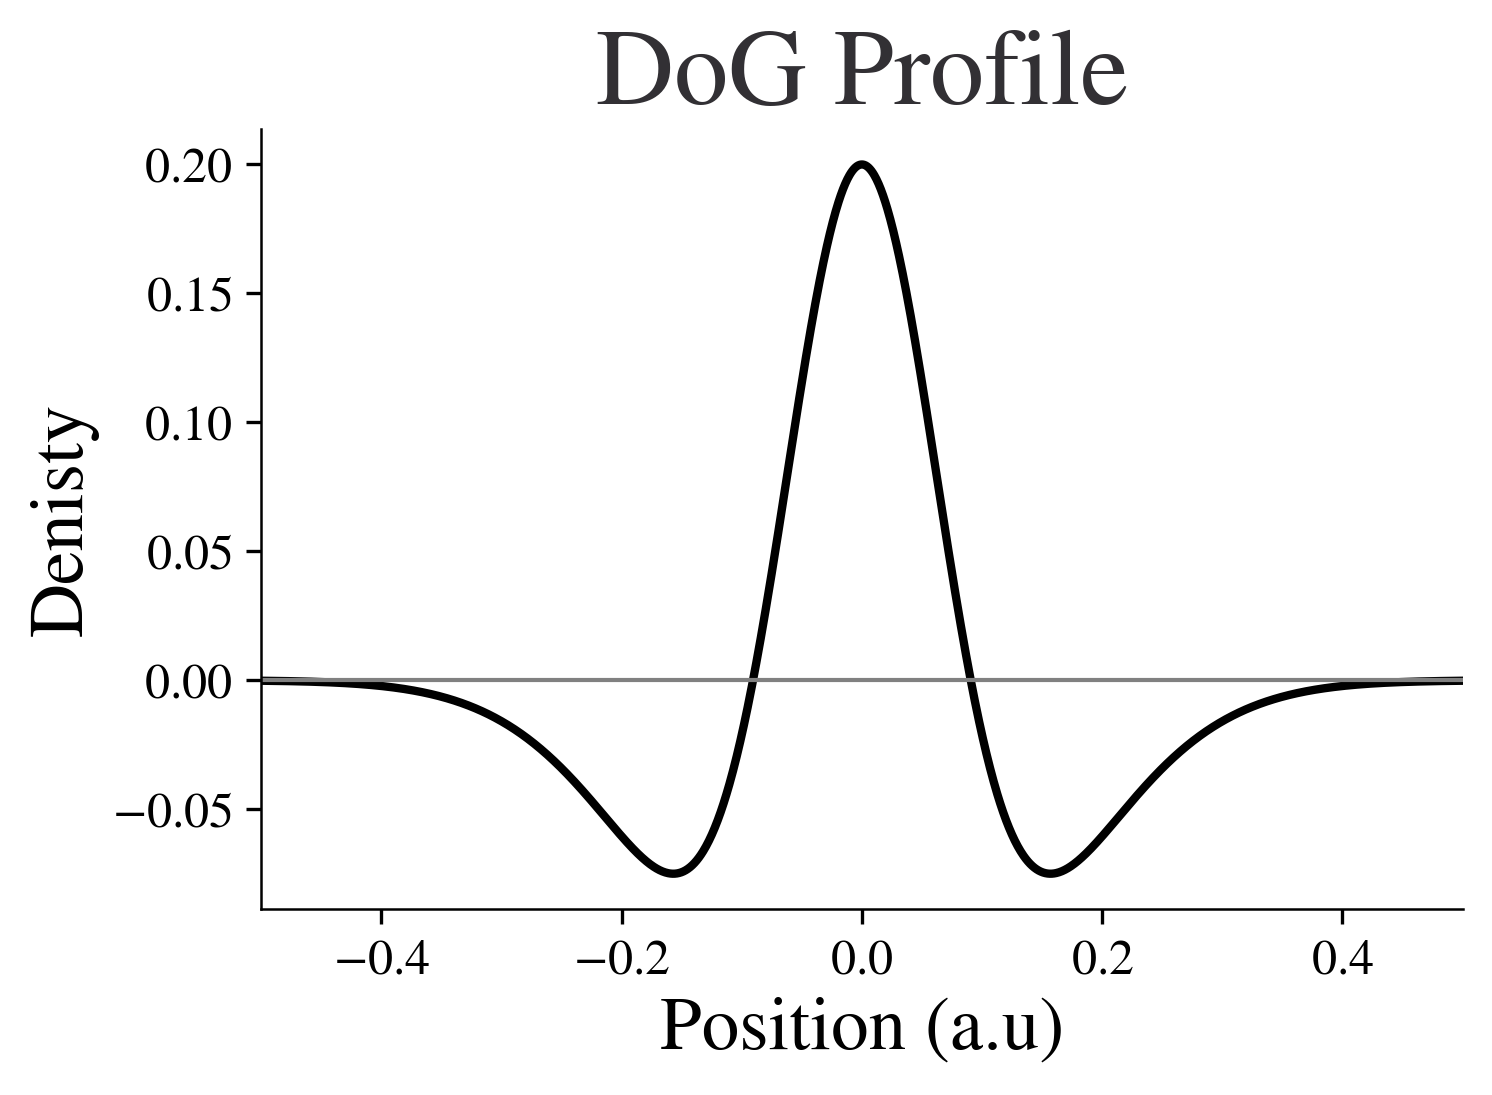

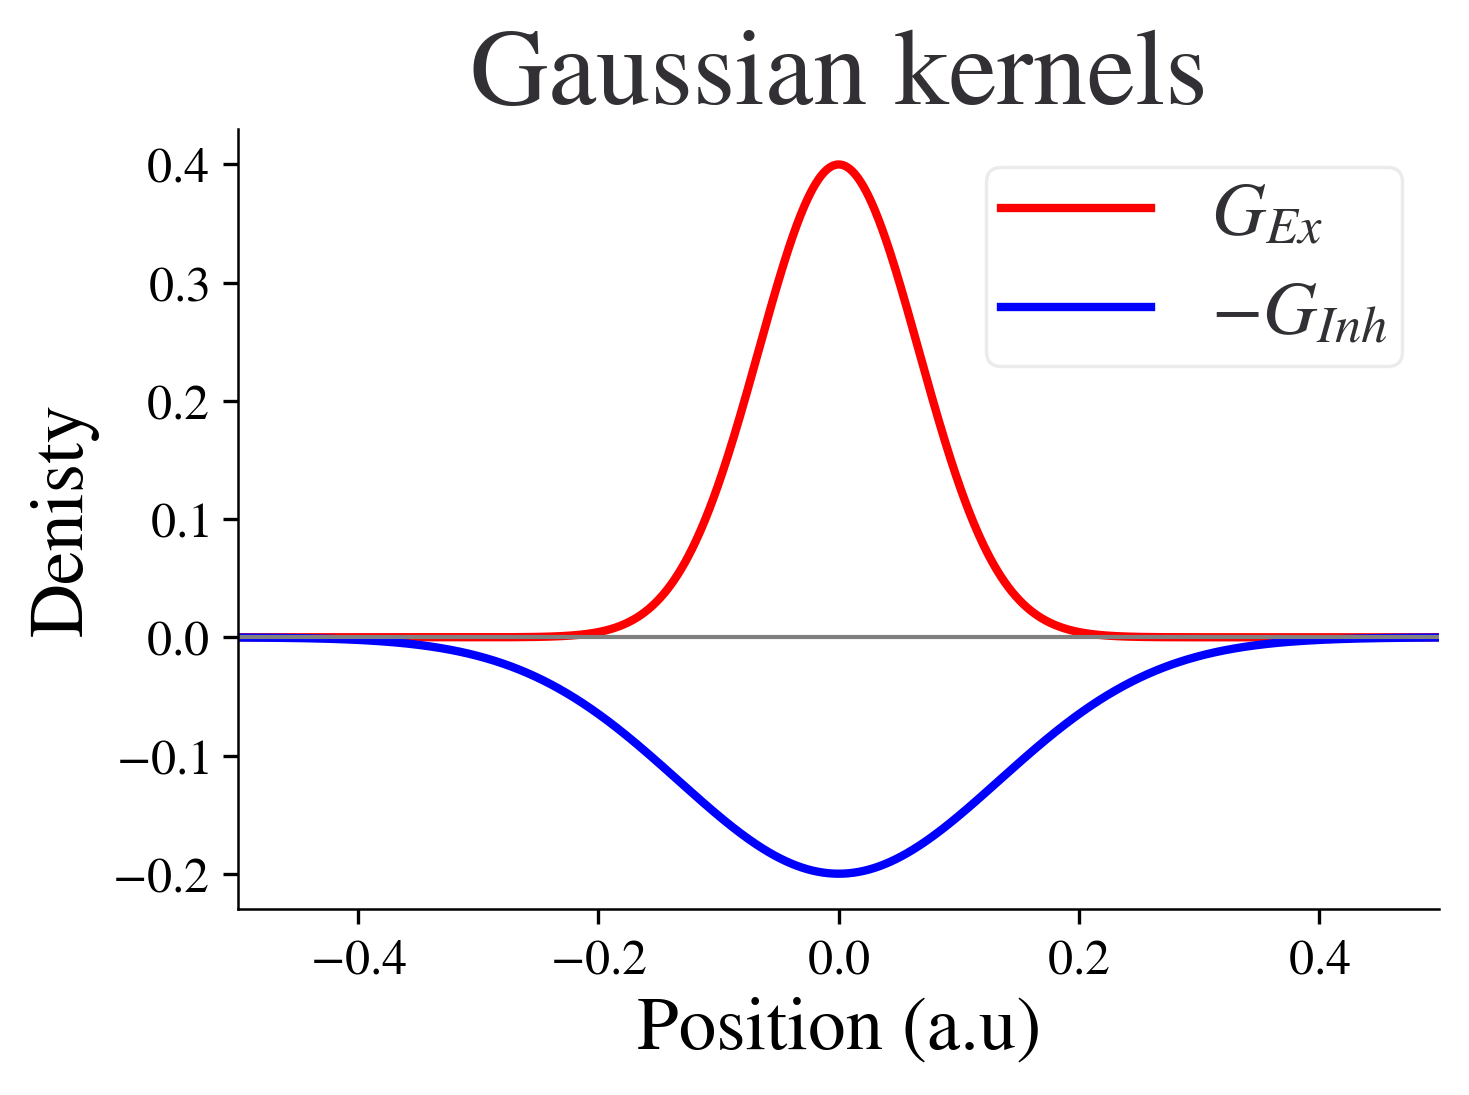

-5.329070518200751e-15


(0.0, 1800.0)

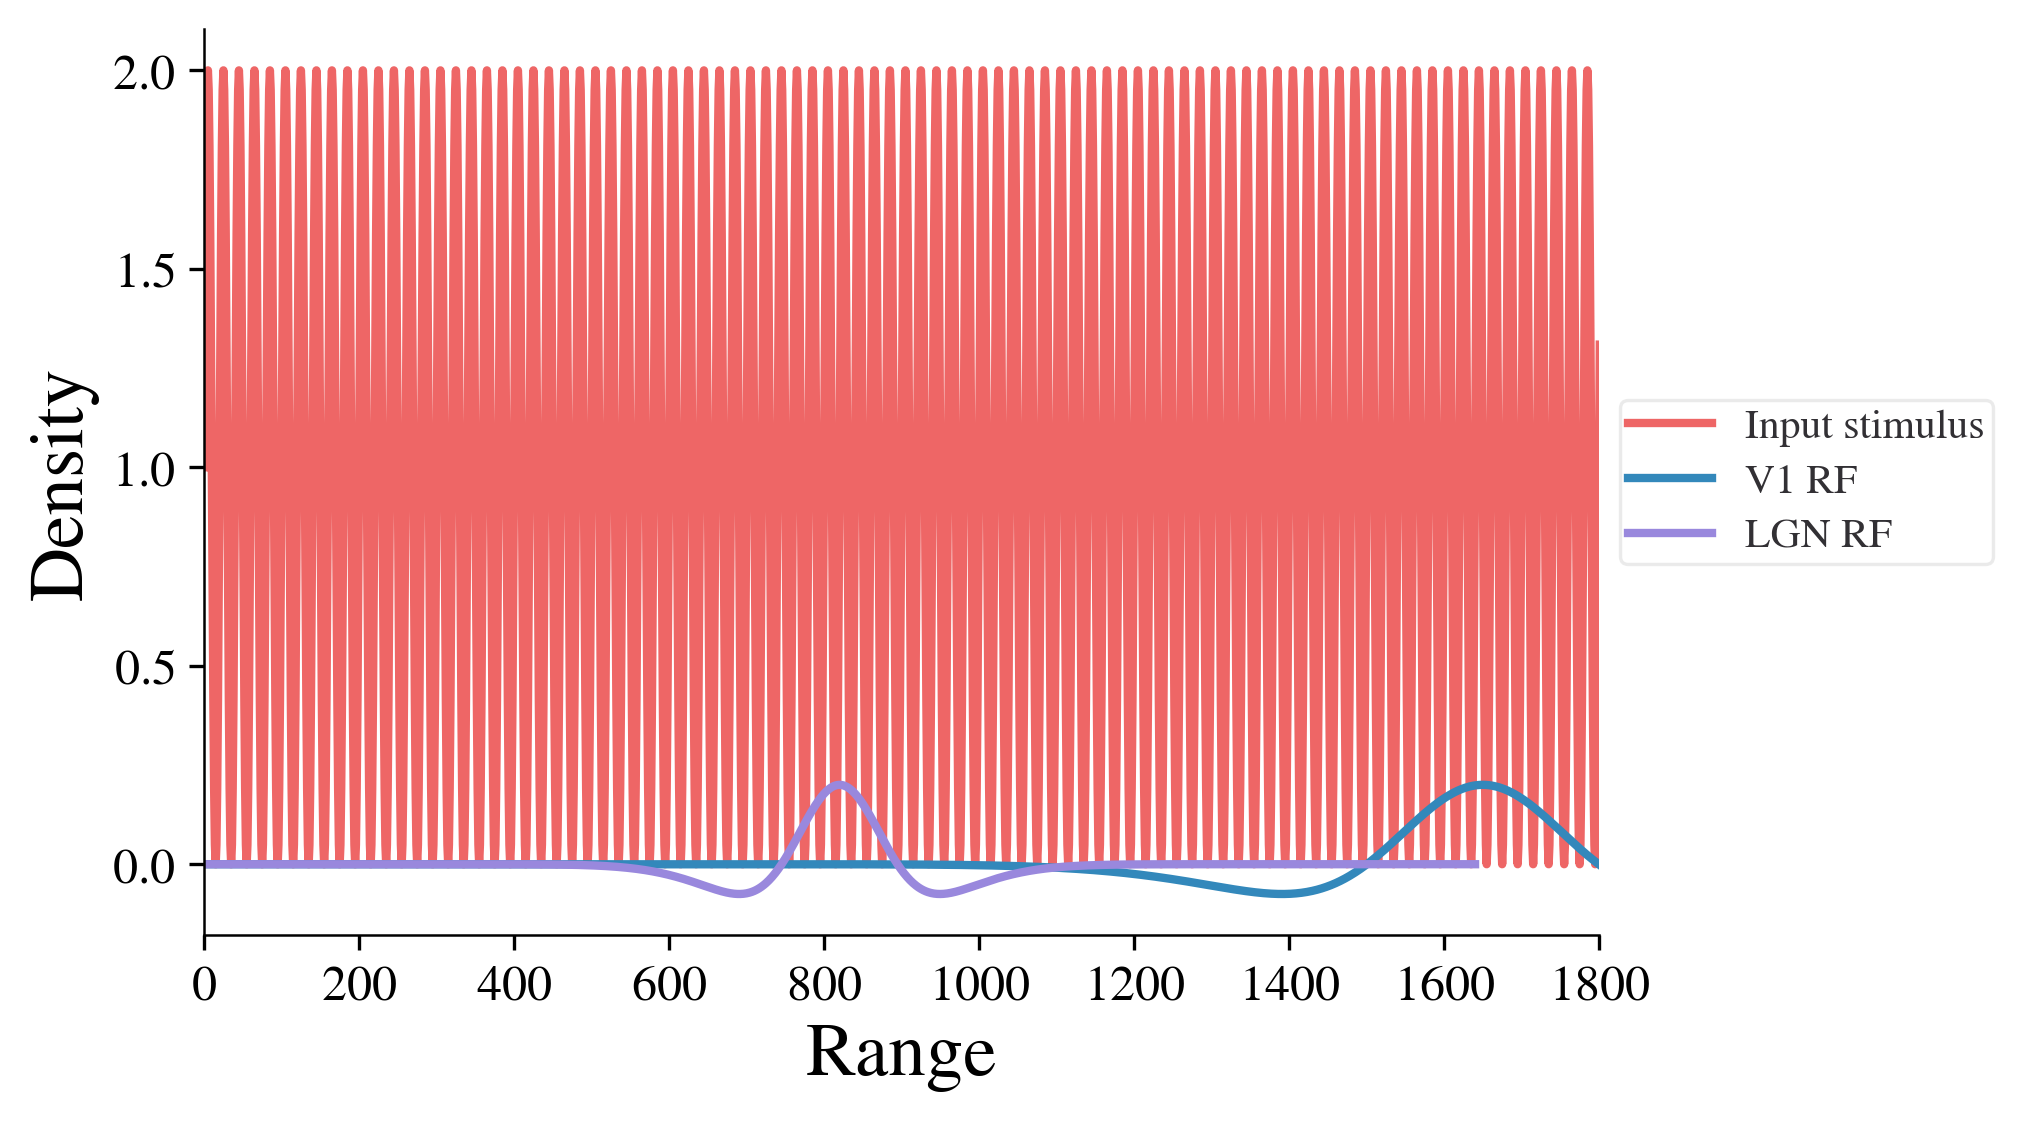

In [16]:
A = 1
B = 115
C = 20
this_amp_exc= 0.4 /B #* 0.1 # h=0.46
this_amp_inh= 0.2 /C #* 5.75*0.1 # h=0.23


t_scale = 0.75
dt = 0.1 

####
unit_2_scale=1
LGN_RF_scale =55
V1_RF_scale = LGN_RF_scale*2
dp=0.1
filter_unit = np.arange(-dp*10*int(LGN_RF_scale*1.5),dp*10*int(LGN_RF_scale*1.5)+dp,dp) 
filter_unit_2 = np.arange(-dp*10*int(V1_RF_scale*1.5)*unit_2_scale,dp*10*int(V1_RF_scale*1.5)*unit_2_scale+dp,dp) 


print(filter_unit)
print(filter_unit_2)

timestep = int(np.round(400 * t_scale ))

T = timestep * dt


boundary_size = 10 
pixel_size = int((4*input_scale+1)*sr+shift-12) #+2*boundary_size

I_CC_norm = normalize(
    I_CC[0:pixel_size],
    {'actual': {'lower': 0, 'upper': 2}, 'desired': {'lower': 0, 'upper': 1}}
) 

I = np.zeros((timestep, pixel_size+2*boundary_size))
I[10:200,boundary_size:-boundary_size] = I_CC_norm


fig = plt.figure(figsize=(s1, s2))

v1_sigma_Ex_scale = 1
v1_sigma_inh_scale =1
v1_amp_scale = 1
# fixed basline scale *3
this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
this_v1_sigma_inh = 0.2*v1_sigma_inh_scale
# this_v1_amp_inh = this_amp_inh*v1_amp_scale


X_vec = np.zeros((timestep,pixel_size+2*boundary_size  ))
X_vec_V1 = np.zeros((timestep,pixel_size+2*boundary_size  ))
t=0
_,norm_G_Ex,norm_G_Inh= net.fun_feedforward(X_vec_V1[t,:],A,B,C,I[t,:],
                                            filter_unit_2,this_v1_sigma_Ex ,
                                            this_v1_sigma_inh,  
                                            amp_inh=this_amp_inh,
                                            RF_scale=V1_RF_scale, amp_exc=this_amp_exc)


plt.figure(figsize=(s1, s2))
plt.plot(np.linspace(-1,1,len(norm_G_Ex)),B*norm_G_Ex-C*norm_G_Inh,c='black')
plt.xlabel("Position (a.u)")
plt.ylabel("Denisty")
plt.axhline(y=0,c='grey',linewidth=1)
plt.title('DoG Profile',loc='center')
plt.xlim([-0.5, 0.5])
plt.show()

plt.figure(figsize=(s1, s2))
plt.plot(np.linspace(-1,1,len(norm_G_Ex)),B*norm_G_Ex,c='r',label=r'$G_{Ex}$')
plt.plot(np.linspace(-1,1,len(norm_G_Ex)),-C*norm_G_Inh,c='b',label=r'$-G_{Inh}$')
plt.xlabel("Position (a.u)")
plt.ylabel("Denisty")
plt.axhline(y=0,c='grey',linewidth=1)
plt.legend(fontsize=18)
plt.xlim([-0.5, 0.5])
plt.title('Gaussian kernels',loc='center')
plt.show()


plt.figure()
plt.plot(np.arange(0,4*input_scale+1,ts)*int(sr),I_CC[0:int((4*input_scale+1)*sr)],label='Input stimulus')
plt.plot(B*norm_G_Ex-C*norm_G_Inh, label='V1 RF')#, label = 'Inhibitory \nGaussian \nKernel')
base_kernel = B*norm_G_Ex-C*norm_G_Inh

print(np.sum(base_kernel))



_,norm_G_Ex,norm_G_Inh= net.fun_feedforward(X_vec[t,:],A,B,C,I[t,:],
                                            filter_unit,dt,dt*2,
                                            amp_inh=this_amp_inh,
                                            RF_scale=LGN_RF_scale,
                                            amp_exc=this_amp_exc
                                           )
plt.plot(B*norm_G_Ex-C*norm_G_Inh, label='LGN RF')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))#, bbox_to_anchor=(1, 0.5))
plt.xlabel("Range")
plt.ylabel("Density")

plt.xlim([0, 1800])

# Figure 6E

0.2499999999999763
0.199999999999976
0.1499999999999757
0.09999999999997544
0.049999999999975175


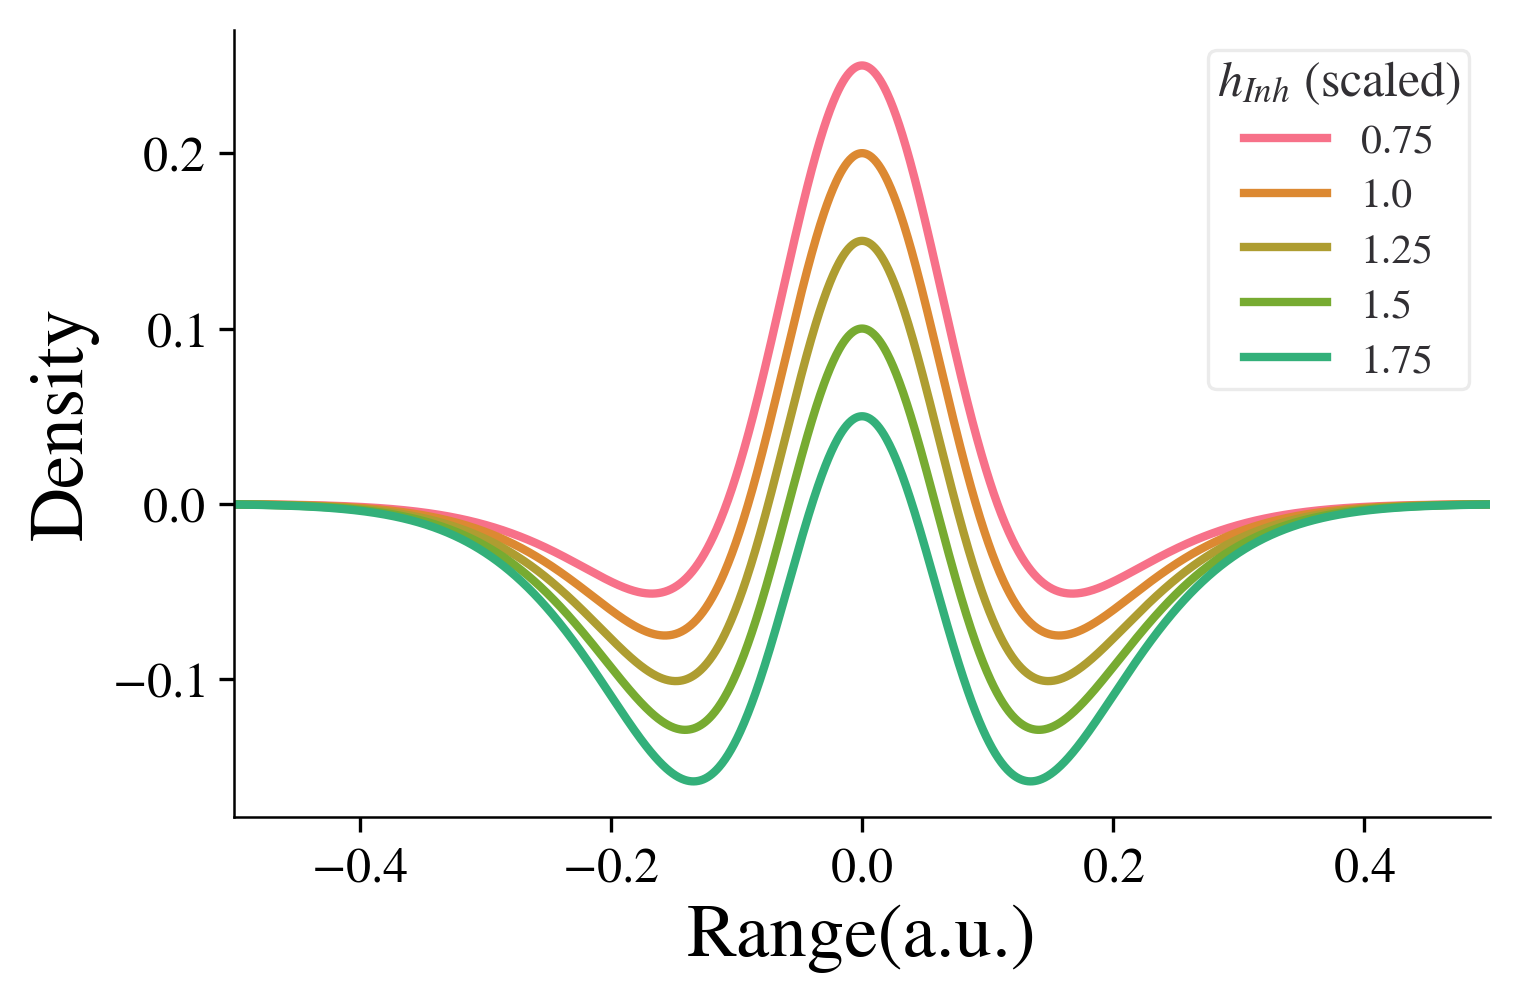

In [17]:
pal=sns.color_palette("husl", 10)


a = pal.as_hex()
colors = cycler('color', a)

plt.rc('axes', facecolor='white', edgecolor='black',
       axisbelow=True, grid=True, prop_cycle= colors)


unit_2_scale = 1
filter_unit = np.arange(-dp*10*int(LGN_RF_scale*1.5),dp*10*int(LGN_RF_scale*1.5)+dp,dp) 
filter_unit_2 = np.arange(-dp*10*int(V1_RF_scale*1.5)*unit_2_scale,dp*10*int(V1_RF_scale*1.5)*unit_2_scale+dp,dp) 

this_amp_exc= 0.4 /B #* 0.1 # h=0.46
this_amp_inh= 0.2 /C #* 5.75*0.1 # h=0.23
this_alpha=0.003*a_scale
this_amp_list =np.array([0.75,1,1.25,1.5,1.75])
X_vec = np.zeros((timestep,pixel_size+2*boundary_size  ))
X_vec_V1 = np.zeros((timestep,pixel_size+2*boundary_size  ))


plt.figure(figsize=(s1, s2))
for v1_amp_scale in tqdm(this_amp_list):

    v1_sigma_Ex_scale = 1 # *unit_2_scale
    v1_sigma_inh_scale =1 # *unit_2_scale

    this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
    this_v1_sigma_inh = 0.2*v1_sigma_inh_scale
    this_v1_amp_inh = this_amp_inh*v1_amp_scale
    
    

    t=0
    _,norm_G_Ex,norm_G_Inh= net.fun_feedforward(X_vec_V1[t,:],A,B,C,I[t,:],filter_unit_2,this_v1_sigma_Ex ,this_v1_sigma_inh,amp_inh=this_v1_amp_inh,RF_scale=V1_RF_scale, amp_exc=this_amp_exc)

    plt.plot(np.linspace(-1,1,len(norm_G_Ex)),B*norm_G_Ex-C*norm_G_Inh,label=str(v1_amp_scale))
    print(np.max(B*norm_G_Ex-C*norm_G_Inh))
    

plt.xlabel("Range(a.u.)")
plt.ylabel("Density")
    

plt.legend(title=r'$h_{Inh}$ (scaled)',loc='upper right')#,  bbox_to_anchor=(1, 0.5))

plt.xlim([-0.5, 0.5])


plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'cc_inh_amp_kernel.'+'png'),dpi=300)
with open(os.path.join(fig_save_path , 'cc_inh_amp_kernel.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)


In [18]:
this_amp_exc= 0.4 /B #* 0.1 # h=0.46
this_amp_inh= 0.2 /C #* 5.75*0.1 # h=0.23


this_amp_list = np.array([0.75,1,1.25,1.5,1.75])#,
v1_inh_amp_response_list = []
this_alpha= 0.003*a_scale

for v1_amp_scale in tqdm(this_amp_list):

    v1_sigma_Ex_scale = 1 # *unit_2_scale
    v1_sigma_inh_scale =1 # v1_amp_scale# *unit_2_scale

    this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
    this_v1_sigma_inh = 0.2*v1_sigma_inh_scale
    this_v1_amp_inh = this_amp_inh*v1_amp_scale

    X_vec,X_vec_2nd,X_vec_V1,X_vec_V1_2nd = net.get_network_output_wider_V1(A,B,C,I,
                                                                            filter_unit, filter_unit_2, dt,
                                                                            timestep, pixel_size, boundary_size,
                                                                            this_alpha=this_alpha,
                                                                            this_amp_inh=this_amp_inh,
                                                                            this_amp_exc=this_amp_exc,
                                                                            v1_sigma_Ex=this_v1_sigma_Ex , 
                                                                            v1_sigma_inh=this_v1_sigma_inh, 
                                                                            v1_amp_inh=this_v1_amp_inh, 
                                                                            LGN_RF_scale=LGN_RF_scale,
                                                                            V1_RF_scale=V1_RF_scale, 
                                                                            v1_amp_exc=this_amp_exc  )


    this_X_vec =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec,time_res=20*t_scale)
    this_X_vec_V1 =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
    this_X_vec_2nd =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_2nd,time_res=20*t_scale)
    this_X_vec_V1_2nd =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
    
    v1_inh_amp_response_list.append (this_X_vec_V1_2nd)
    


# Figure 6B, 6A

0 : 146.69732661393107
37.80069143317829
1 : 131.4066196824461
33.446120411221344
2 : 118.82045539806848
29.412442315915342
3 : 108.52415086166275
25.705298356233392
4 : 99.22277147632934
22.33080818613489


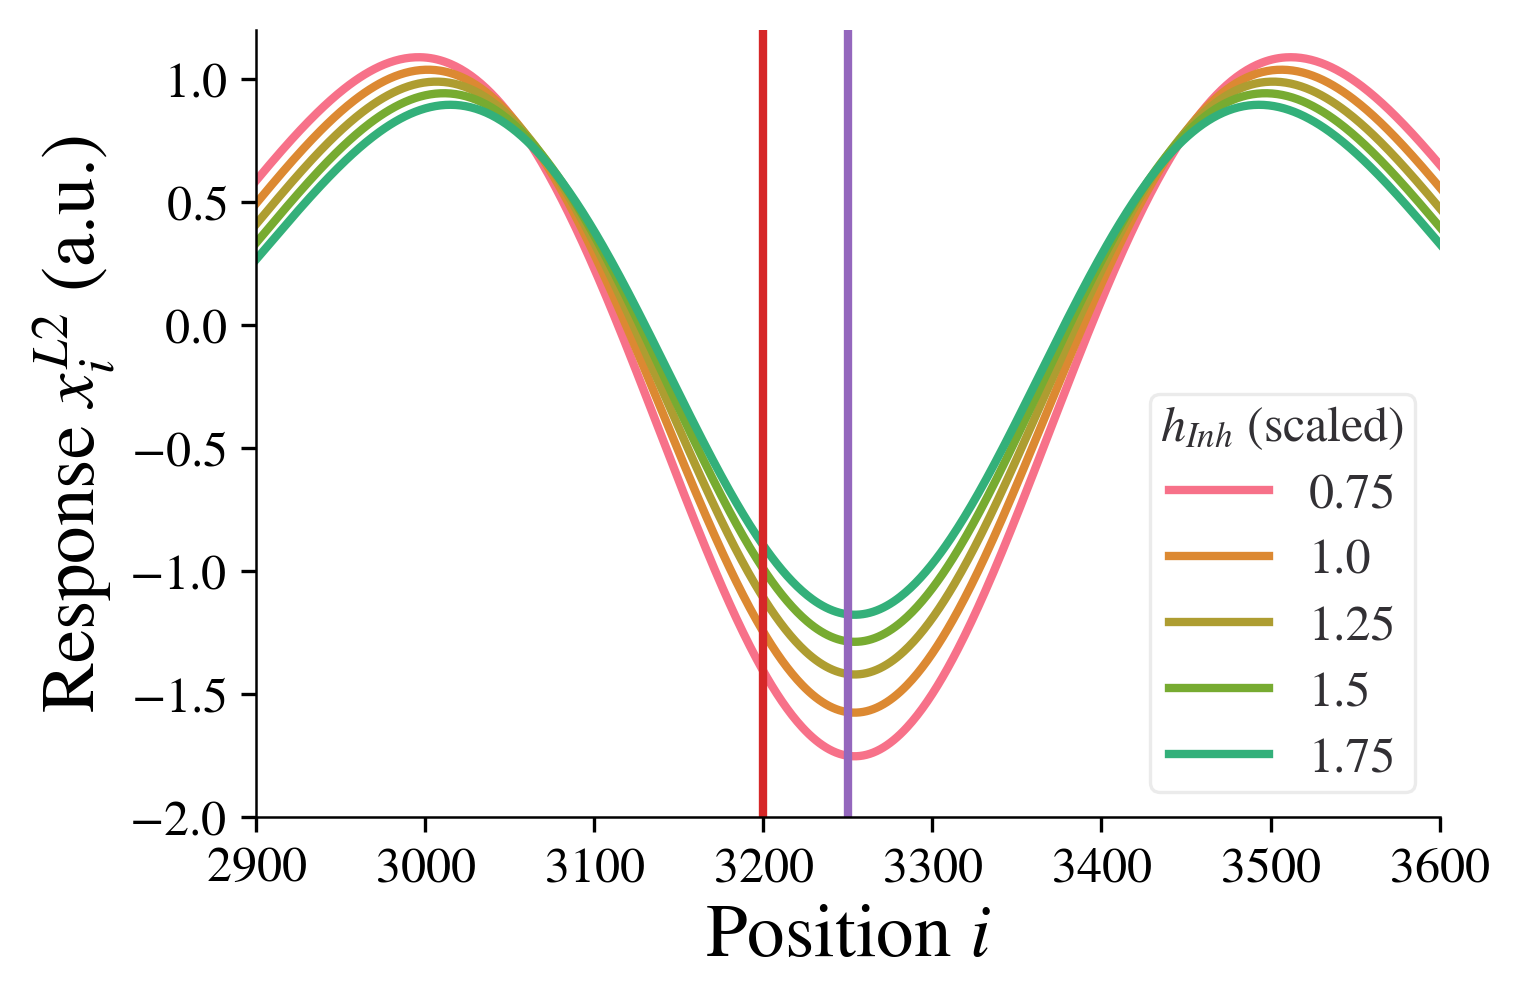

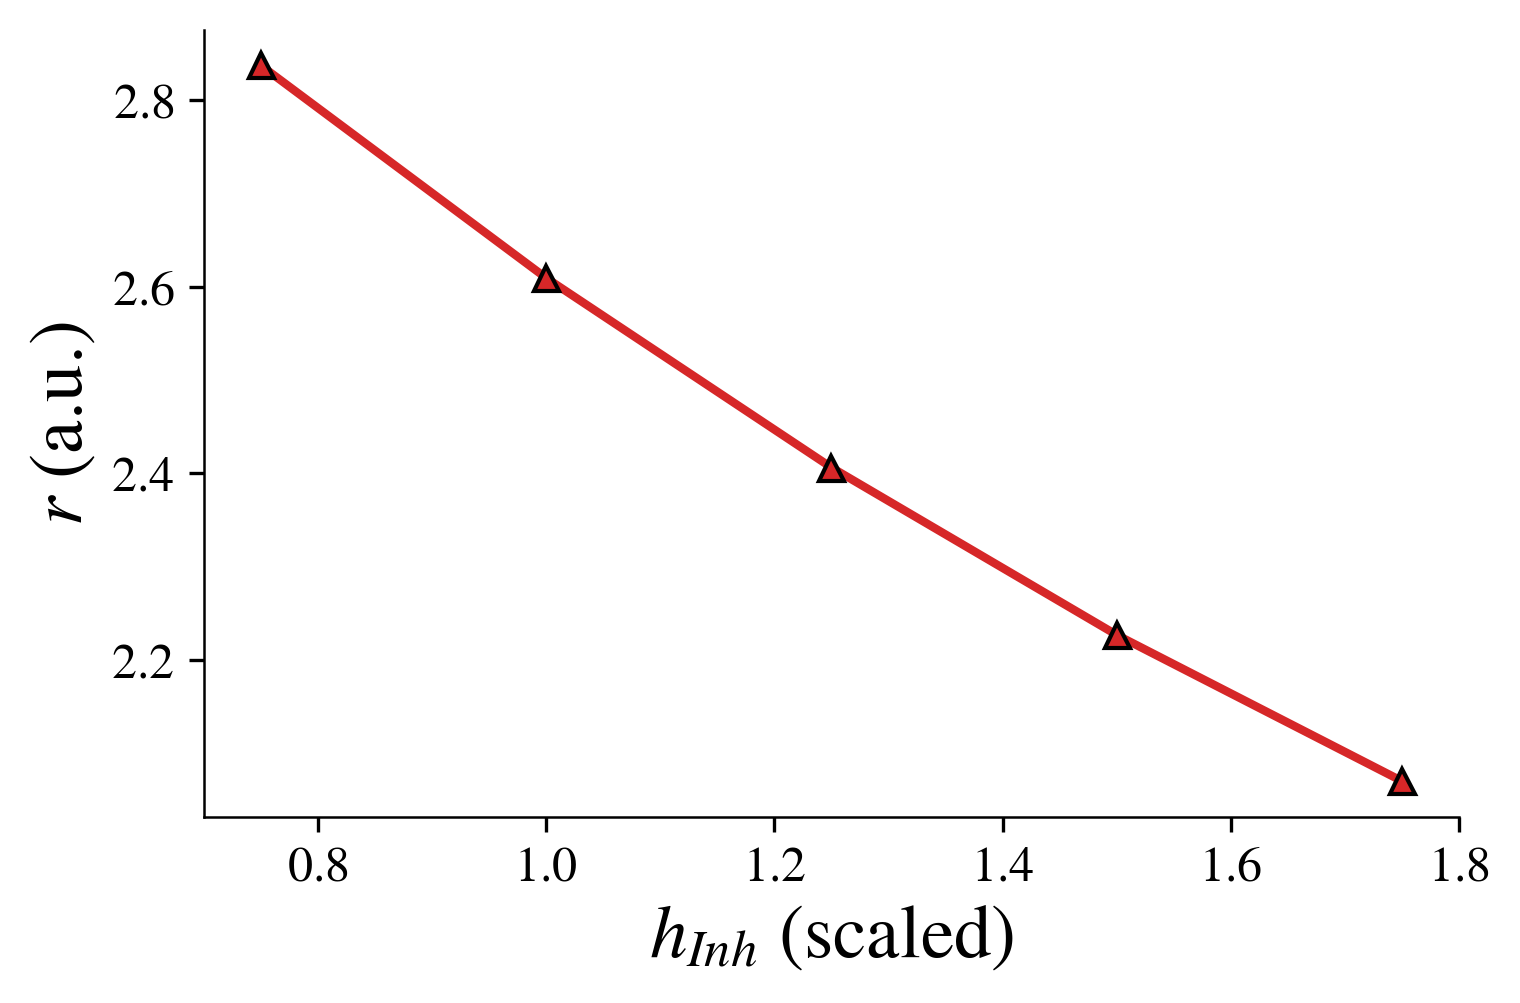

In [19]:
pal=sns.color_palette("husl", 10)


a = pal.as_hex()
colors = cycler('color', a)

plt.figure(figsize=(s1, s2))
this_amp_list = np.array([0.75,1,1.25,1.5,1.75])

r_list= []
v1_inh_amp_response_list = np.array(v1_inh_amp_response_list )
for i in range(len(this_amp_list)):
    plt.plot(np.arange(0,pixel_size,1),v1_inh_amp_response_list[i][180,boundary_size:-boundary_size], label=str(this_amp_list[i]))
    this_response =v1_inh_amp_response_list[i][180,boundary_size:-boundary_size]

    mark_pos= int(2*input_scale*sr)
    win_left = this_response[mark_pos-300:mark_pos]
    win_left_st = np.argmax(win_left)
    win_left_ed = np.argmin(win_left) 
    
    if win_left_st<win_left_ed:
        r_surround= np.sum(np.abs(win_left[win_left_st:win_left_ed]))
    else:
        r_surround= np.sum(np.abs(win_left[win_left_ed:win_left_st]))
    
    
    win_right = this_response[mark_pos:mark_pos+50]
    
    win_right_st = np.argmax(win_right)
    win_right_ed = np.argmin(win_right) 
    
    if win_right_st>win_right_ed:
        r_center= np.sum(np.abs(win_left[win_right_ed:win_right_st]))
    else:
        r_center= np.sum(np.abs(win_left[win_right_st:win_right_ed]))
    
    print(i,":",r_surround)
    print(r_center)
    r_list.append(np.max(win_left)-np.min(win_right))

plt.xlabel('Position $i$')
plt.ylabel('Response $x^{L2}_{i}$ (a.u.)')

plt.axvline(x=mark_pos+50,color='tab:purple')
plt.axvline(x=mark_pos+0,color='tab:red')

plt.legend(title=r'$h_{Inh}$ (scaled)',loc='lower right',fontsize=12, title_fontsize=12 )#bbox_to_anchor=(1, 0.5))

plt.xlim(mark_pos-300,mark_pos+400 )

plt.ylim([-2, 1.2])
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path ,'cc_inh_amp_response.'+'png'),dpi=300)
with open(os.path.join(fig_save_path , 'cc_inh_amp_response.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)


plt.figure(figsize=(s1, s2))

plt.plot(this_amp_list,r_list,marker='^',c='tab:red')
plt.xlabel(r'$h_{Inh}$ (scaled)')
plt.ylabel(r'$r$ (a.u.)')
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'cc_inh_amp_rep.'+'png'),dpi=300)
with open(os.path.join(fig_save_path , 'cc_inh_amp_rep.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)



# Figure 3E

0.01
0.0034782608695652175
0.01
0.0034782608695652175
0.01
0.0034782608695652175
0.01
0.0034782608695652175
0.01
0.0034782608695652175
0.01
0.0034782608695652175


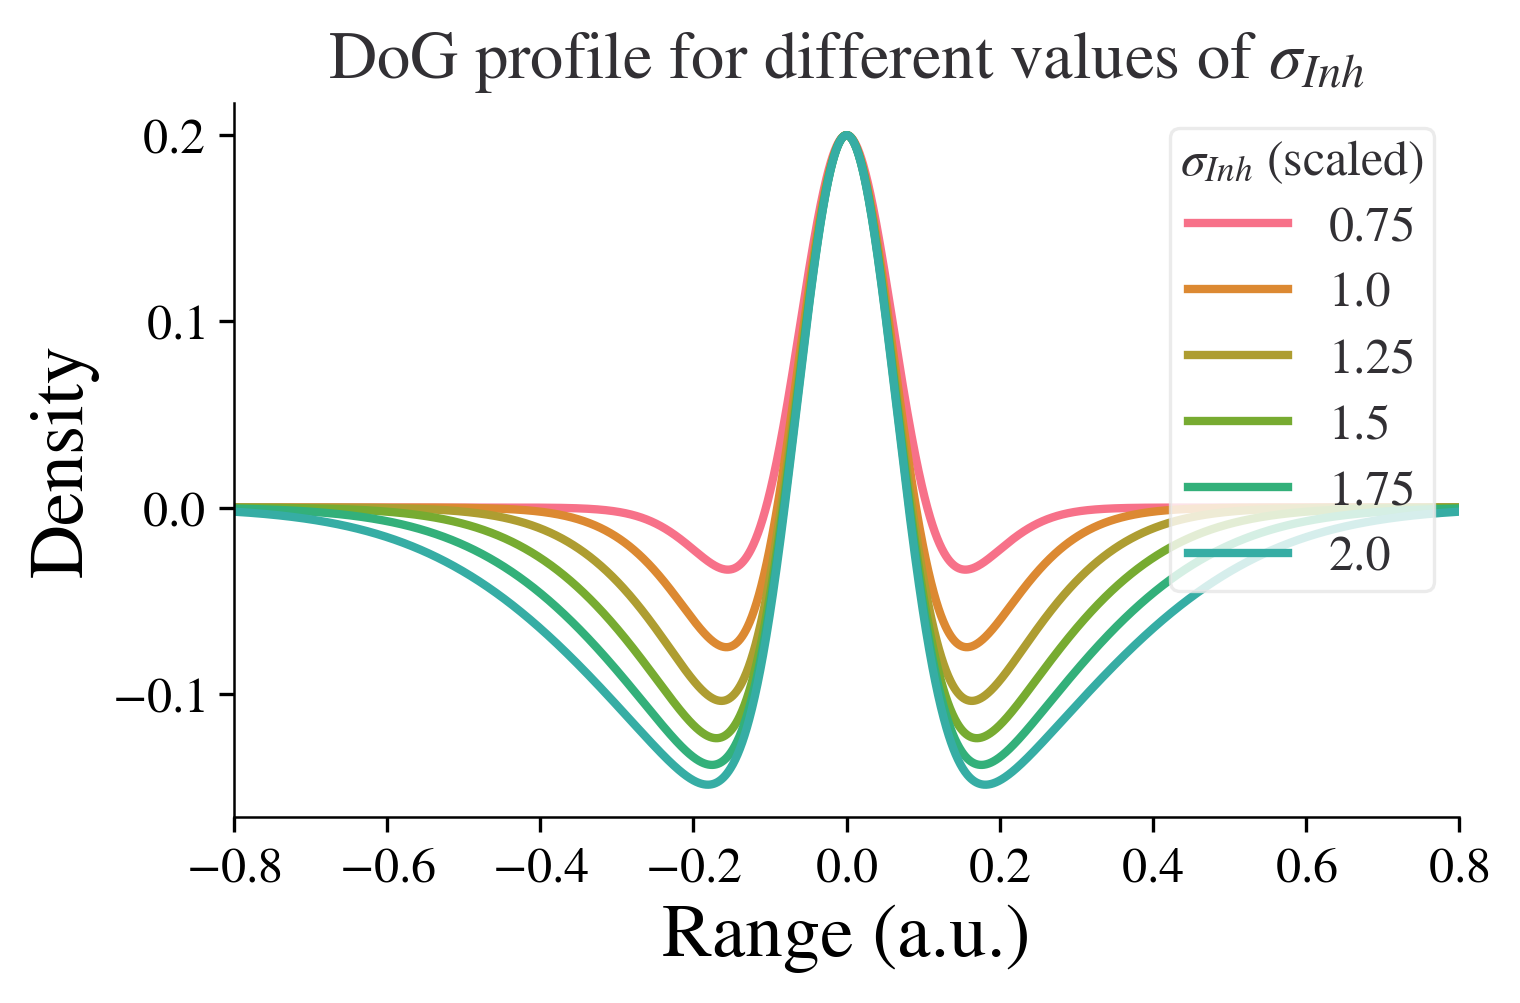

In [20]:
this_amp_exc= 0.4 /B #* 0.1 # h=0.46
this_amp_inh= 0.2 /C #* 5.75*0.1 # h=0.23


pal=sns.color_palette("husl", 10)


a = pal.as_hex()
colors = cycler('color', a)

plt.rc('axes', facecolor='white', edgecolor='black',
       axisbelow=True, grid=True, prop_cycle= colors)


unit_2_scale = 1
filter_unit = np.arange(-dp*10*int(LGN_RF_scale*1.5),dp*10*int(LGN_RF_scale*1.5)+dp,dp) 
filter_unit_2 = np.arange(-dp*10*int(V1_RF_scale*1.5)*unit_2_scale,dp*10*int(V1_RF_scale*1.5)*unit_2_scale+dp,dp) 

this_alpha=0.003*a_scale
this_sig_list =np.array([0.75,1,1.25,1.5,1.75,2])*1
X_vec = np.zeros((timestep,pixel_size+2*boundary_size  ))
X_vec_V1 = np.zeros((timestep,pixel_size+2*boundary_size  ))


plt.figure(figsize=(s1, s2))

for v1_inh_sigma_scale in tqdm(this_sig_list):
    v1_sigma_Ex_scale = 1 # *unit_2_scale
    v1_sigma_inh_scale =1 * v1_inh_sigma_scale# *unit_2_scale
    v1_amp_scale = 1
    this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
    this_v1_sigma_inh = 0.2*v1_sigma_inh_scale
    
    print(this_amp_inh)
    print(this_amp_exc)
    
    

    t=0
    _,norm_G_Ex,norm_G_Inh= net.fun_feedforward(X_vec_V1[t,:],A,B,C,I[t,:],filter_unit_2,this_v1_sigma_Ex ,this_v1_sigma_inh,amp_inh=this_amp_inh,RF_scale=V1_RF_scale, amp_exc=this_amp_exc)


    plt.plot(np.linspace(-1,1,len(norm_G_Ex)),B*norm_G_Ex-C*norm_G_Inh,label=str(v1_inh_sigma_scale))

plt.xlabel("Range (a.u.)")
plt.ylabel("Density")
    

plt.legend(title='$\sigma_{Inh}$ (scaled)',loc='upper right',fontsize=12, title_fontsize=12)#,  bbox_to_anchor=(1, 0.5))
plt.xlim([-0.8,0.8])

plt.title('DoG profile for different values of $\sigma_{Inh}$', loc='center',fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'cc_inh_sig_kernel.'+'png'), dpi=300)
with open(os.path.join(fig_save_path , 'cc_inh_sig_kernel.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)



In [21]:
this_amp_exc= 0.4 /B #* 0.1 # h=0.46
this_amp_inh= 0.2 /C #* 5.75*0.1 # h=0.23


this_inh_list = [0.75,1,1.25,1.5,1.75,2]#,
v1_inh_sigma_response_list = []
this_alpha=0.003*a_scale
v1_amp_scale=1
for v1_inh_scale in tqdm(this_inh_list):

    v1_sigma_Ex_scale = 1 # *unit_2_scale
    v1_sigma_inh_scale =1 * v1_inh_scale # *unit_2_scale
    v1_amp_scale = 1
    this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
    this_v1_sigma_inh = 0.2*v1_sigma_inh_scale
    this_v1_amp_inh = this_amp_inh*v1_amp_scale


    X_vec,X_vec_2nd,X_vec_V1,X_vec_V1_2nd = net.get_network_output_wider_V1(A,B,C,I,
                                                                            filter_unit, filter_unit_2, dt,
                                                                            timestep, pixel_size, boundary_size,
                                                                            this_alpha=this_alpha,
                                                                            this_amp_inh=this_amp_inh,
                                                                            this_amp_exc=this_amp_exc,
                                                                            v1_sigma_Ex=this_v1_sigma_Ex , v1_sigma_inh=this_v1_sigma_inh, 
                                                                            v1_amp_inh=this_v1_amp_inh, 
                                                                            LGN_RF_scale=LGN_RF_scale,
                                                                            V1_RF_scale=V1_RF_scale, 
                                                                            v1_amp_exc=this_amp_exc  )


    this_X_vec =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec,time_res=20*t_scale)
    this_X_vec_V1 =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
    this_X_vec_2nd =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_2nd,time_res=20*t_scale)
    this_X_vec_V1_2nd =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
    
    v1_inh_sigma_response_list.append (this_X_vec_V1_2nd)
    




In [22]:
np.shape(v1_inh_sigma_response_list)

(6, 300, 6528)

# Figure 3B, 3A

0 : 86.01779384711699
19.536580070647382
1.804930523019317
1 : 131.4066196824461
33.446120411221344
2.609418389468231
2 : 164.75982510444248
44.96254863452358
3.1005972883157265
3 : 184.32666645241753
51.6416938128456
3.3637870158323366
4 : 195.55801062174692
54.99353179855181
3.5012342449460245
5 : 201.07585645683827
56.42594876535813
3.5726571499267323


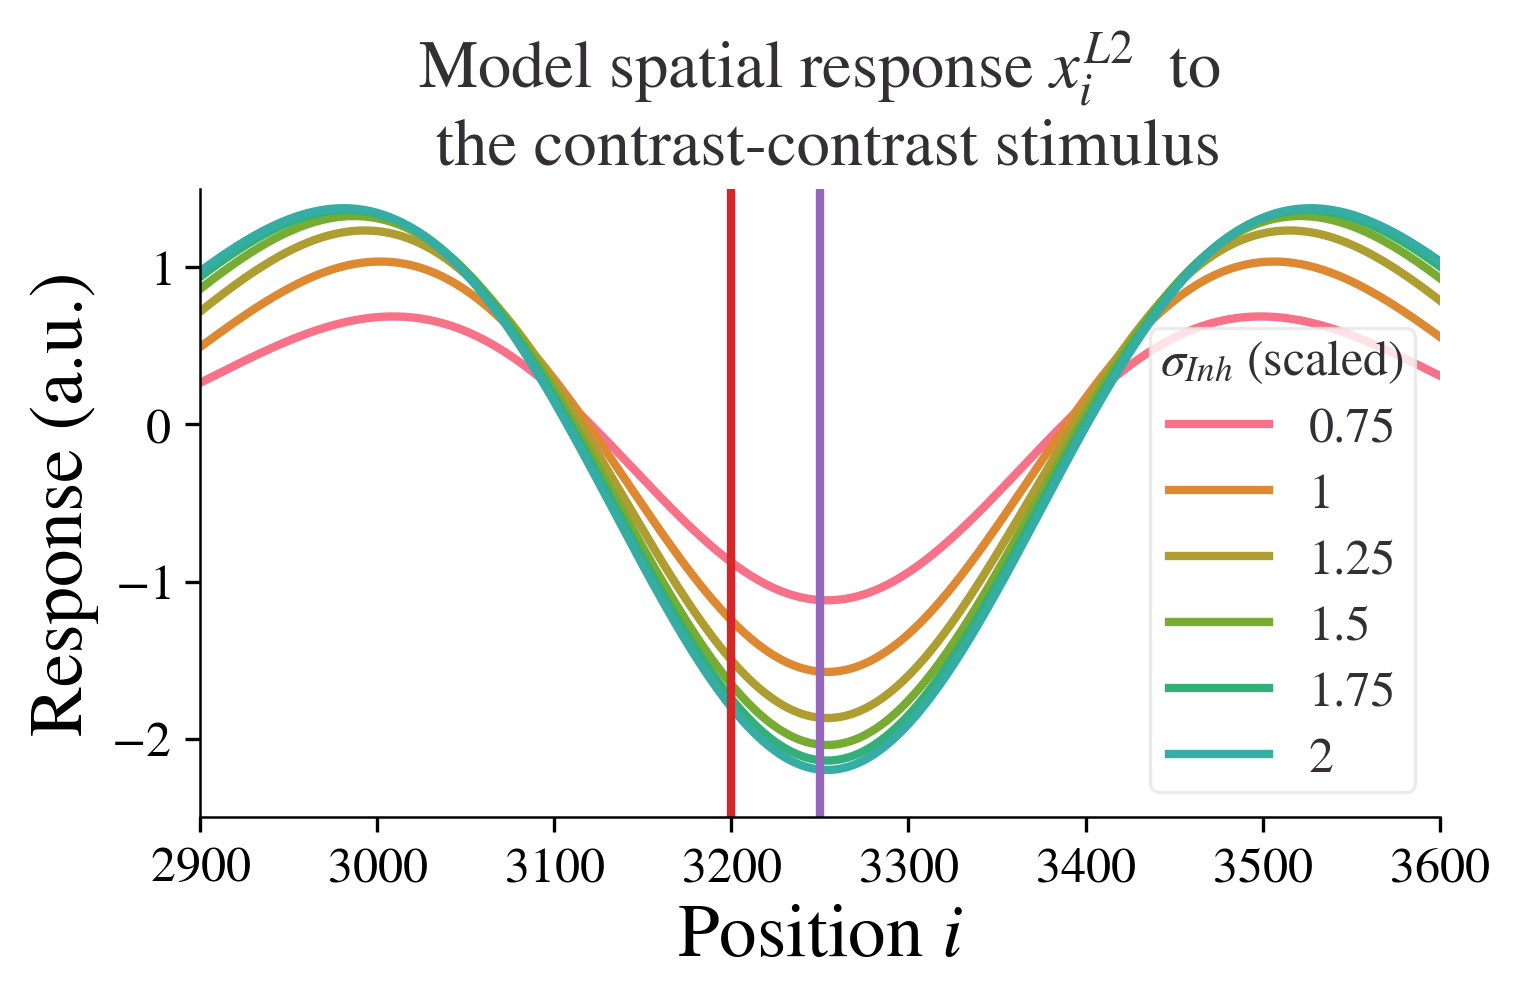

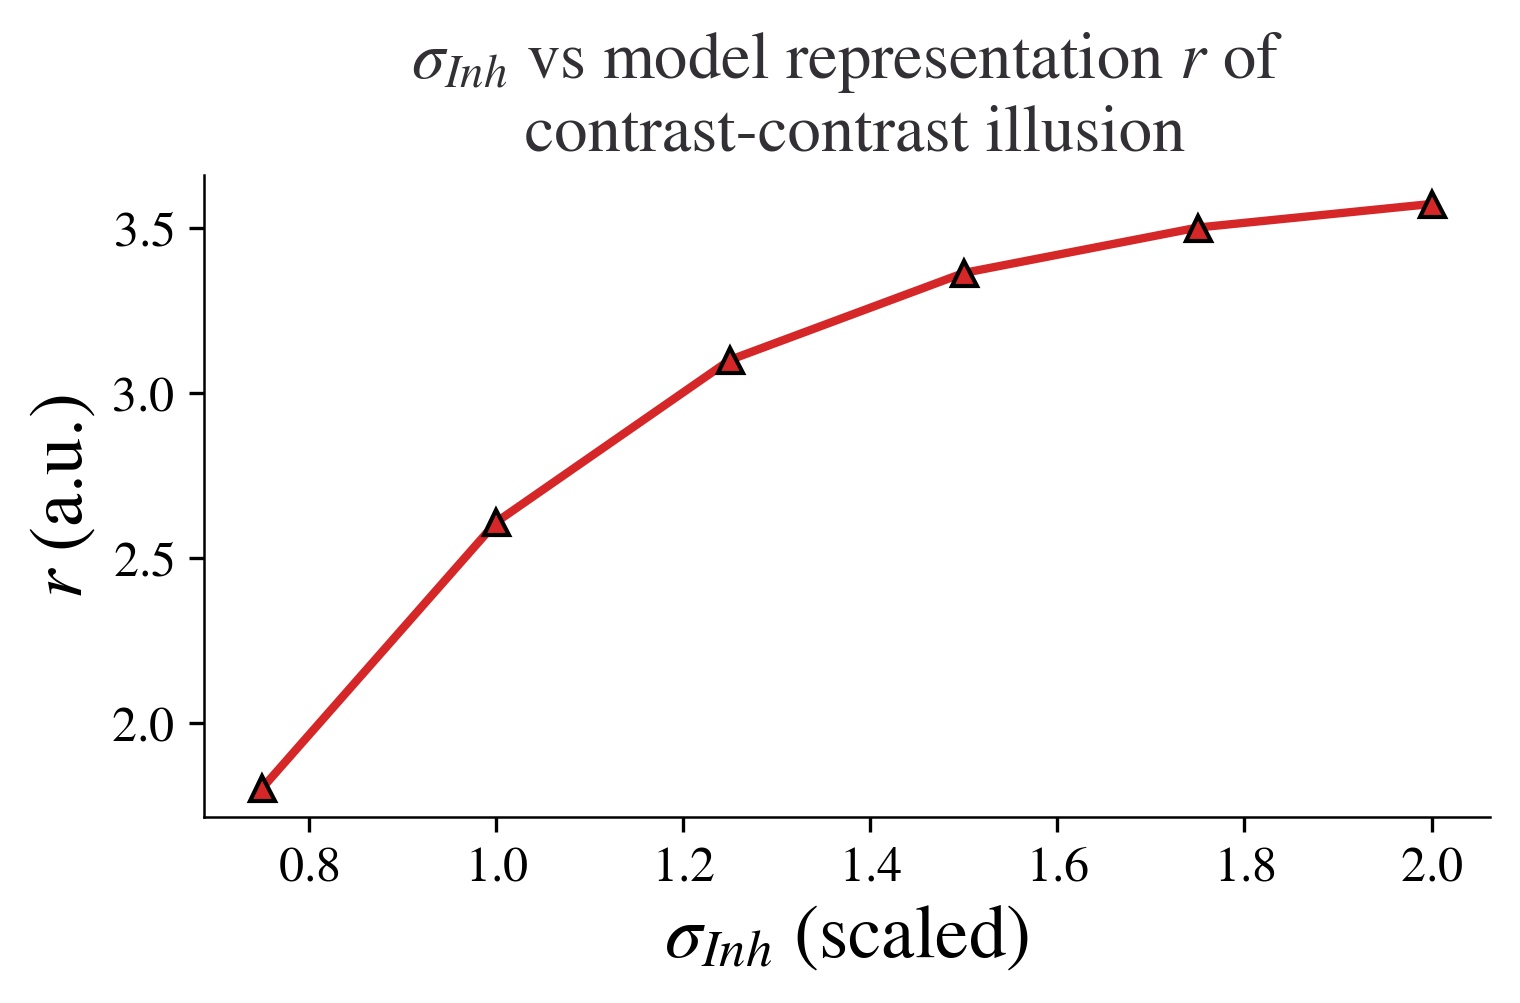

In [23]:

plt.figure(figsize=(s1, s2))


r_list= []
for i in range(len(this_inh_list)):
    plt.plot(np.arange(0,pixel_size,1),v1_inh_sigma_response_list[i][180,boundary_size:-boundary_size], label=str(this_inh_list[i]))
    this_response = v1_inh_sigma_response_list[i][180,boundary_size:-boundary_size]

    mark_pos= int(2*input_scale*sr)
    win_left = this_response[mark_pos-300:mark_pos]
    win_left_st = np.argmax(win_left)
    win_left_ed = np.argmin(win_left) 
    
    if win_left_st<win_left_ed:
        r_surround= np.sum(np.abs(win_left[win_left_st:win_left_ed]))
    else:
        r_surround= np.sum(np.abs(win_left[win_left_ed:win_left_st]))
    
    
    win_right = this_response[mark_pos:mark_pos+50]
    
    win_right_st = np.argmax(win_right)
    win_right_ed = np.argmin(win_right) 
    
    if win_right_st>win_right_ed:
        r_center= np.sum(np.abs(win_left[win_right_ed:win_right_st]))
    else:
        r_center= np.sum(np.abs(win_left[win_right_st:win_right_ed]))
    print(i,":",r_surround)
    print(r_center)
    r_list.append(np.abs(np.max(win_left)-np.min(win_right)))
    print(np.max(win_left)-np.min(win_right))

plt.xlabel('Position $i$')
plt.ylabel('Response (a.u.)')

plt.axvline(x=mark_pos+50,color='tab:purple')
plt.axvline(x=mark_pos+0,color='tab:red')


plt.legend(title='$\sigma_{Inh}$ (scaled)',loc='lower right',fontsize=12, title_fontsize=12)#,  bbox_to_anchor=(1, 0.5))
plt.title('Model spatial response $x^{L2}_{i}$  to \n the contrast-contrast stimulus', loc='center',fontsize=16 )

plt.xlim(mark_pos-300,mark_pos+400 )

plt.ylim([-2.5, 1.5])


plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'cc_inh_sig_response.'+'png'),dpi=300)
with open(os.path.join(fig_save_path , 'cc_inh_sig_response.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)
    


plt.figure(figsize=(s1, s2))

plt.plot(this_inh_list,r_list,marker='^',c='tab:red')
plt.xlabel(r'$\sigma_{Inh}$ (scaled)')
plt.ylabel(r'$r$ (a.u.)')

plt.title('$\sigma_{Inh}$ vs model representation $r$ of \n contrast-contrast illusion', loc='center',fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'cc_inh_sig_rep.'+'png'),dpi=300)
with open(os.path.join(fig_save_path , 'cc_inh_sig_rep.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)
    






## Feedback

In [24]:
this_amp_exc= 0.4 /B #* 0.1 # h=0.46
this_amp_inh= 0.2 /C #* 5.75*0.1 # h=0.23

alpha_list = np.array([0.003,0.002,0.001,0])*a_scale
alpha_r_list = []

alpha_response_list = []
v1_inh_sigma_scale =1
for this_alpha in tqdm(alpha_list):

    v1_sigma_Ex_scale = 1 # *unit_2_scale
    v1_sigma_inh_scale =1 * v1_inh_sigma_scale   # *unit_2_scale
    
    this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
    this_v1_sigma_inh = 0.2*v1_sigma_inh_scale
    this_v1_amp_inh = this_amp_inh*1 #v1_amp_scale


    X_vec,X_vec_2nd,X_vec_V1,X_vec_V1_2nd =net.get_network_output_wider_V1(A,B,C,I,
                                                                            filter_unit, filter_unit_2, dt,
                                                                            timestep, pixel_size, boundary_size,
                                                                            this_alpha=this_alpha,
                                                                            this_amp_inh=this_amp_inh,
                                                                            this_amp_exc=this_amp_exc,
                                                                            v1_sigma_Ex=this_v1_sigma_Ex , 
                                                                            v1_sigma_inh=this_v1_sigma_inh, 
                                                                            v1_amp_inh=this_v1_amp_inh, 
                                                                            LGN_RF_scale=LGN_RF_scale,
                                                                            V1_RF_scale=V1_RF_scale, 
                                                                            v1_amp_exc=this_amp_exc  )

    this_X_vec =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec,time_res=20*t_scale)
    this_X_vec_V1 =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
    this_X_vec_2nd =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_2nd,time_res=20*t_scale)
    this_X_vec_V1_2nd =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
    

    alpha_response_list.append (this_X_vec_V1_2nd)
    


        
    

        

# Figure 4B, 4A

0 : 131.4066196824461
33.446120411221344
1 : 91.60398640557003
23.297685109403883
2 : 51.84868944733836
13.10477096673165
3 : 12.306988402033923
2.8516938976872592


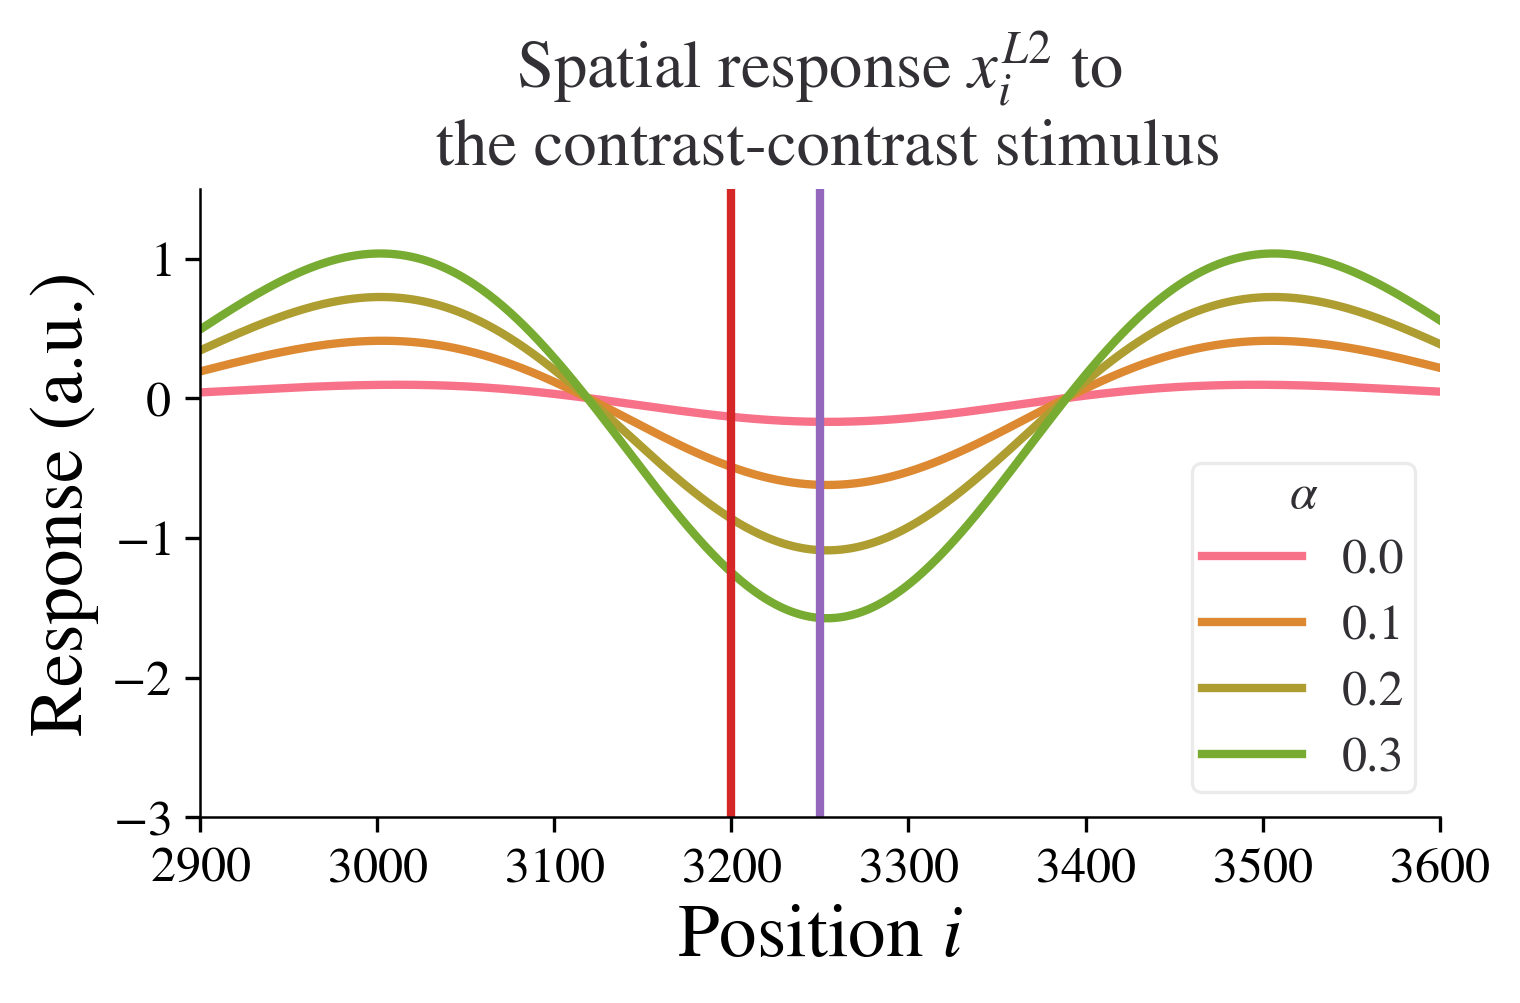

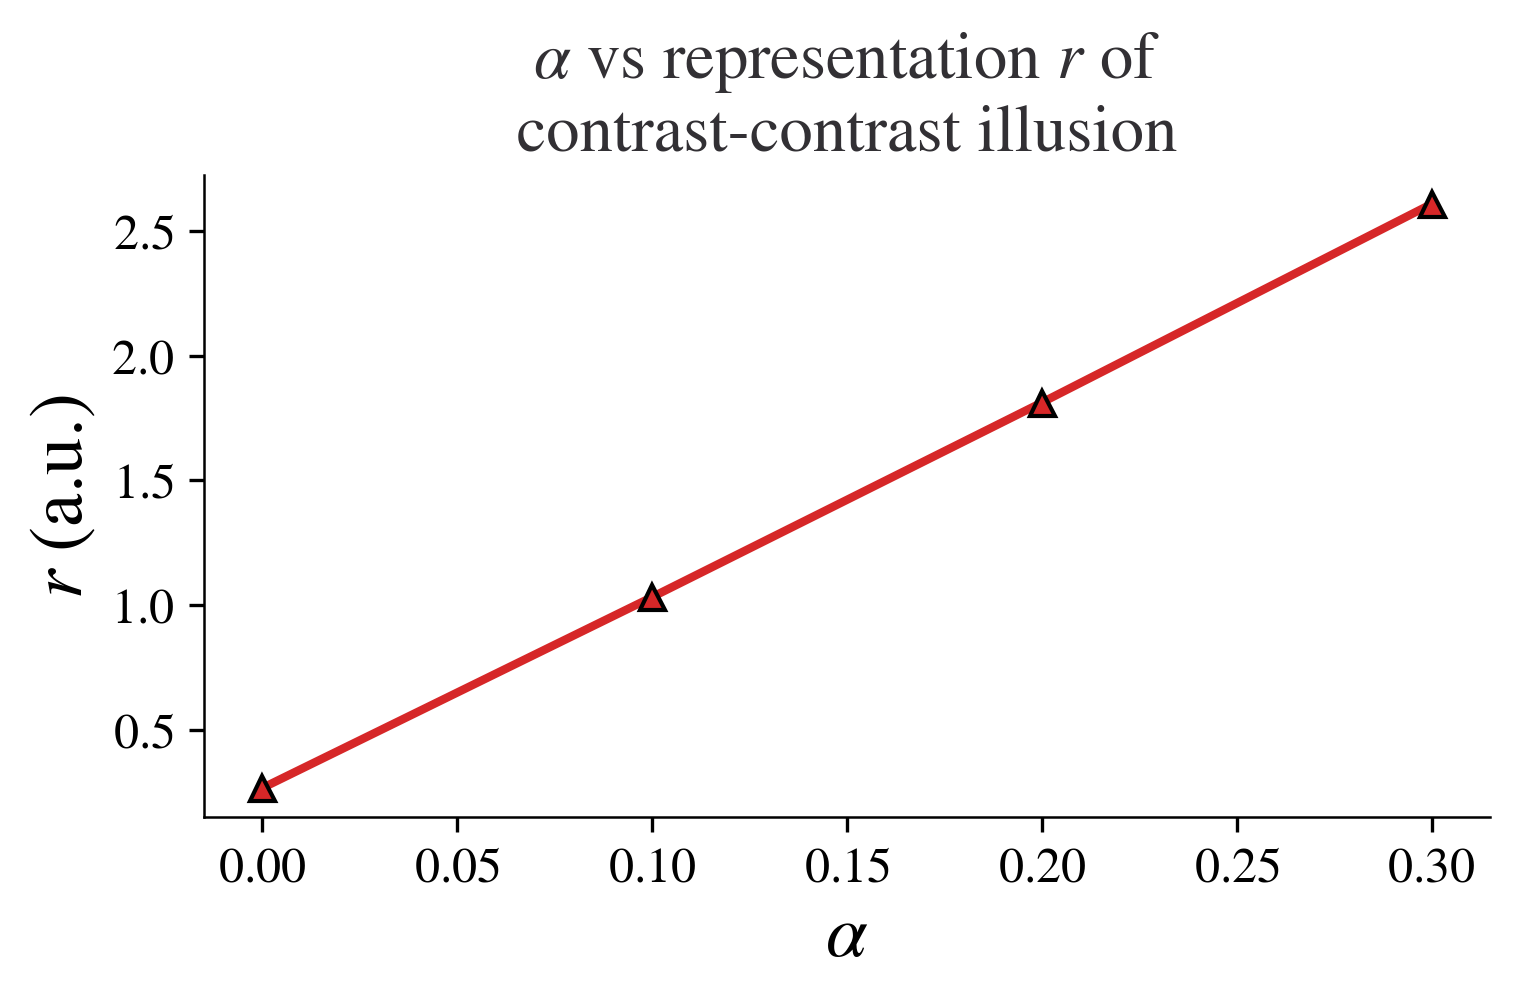

In [25]:
alpha_r_list = []

plt.figure(figsize=(s1, s2))

this_amp_exc= 0.4 /B #* 0.1 # h=0.46
this_amp_inh= 0.2 /C #* 5.75*0.1 # h=0.23

for i in range(len(alpha_list)): 
    this_x = np.arange(0,pixel_size,1)
    this_y = alpha_response_list[-1-i][180,boundary_size:-boundary_size]
    plt.plot(this_x,this_y, label=str(alpha_list[-1-i]))

    this_response = alpha_response_list[i][180,boundary_size:-boundary_size]
    mark_pos= int(2*input_scale*sr)
    win_left = this_response[mark_pos-300:mark_pos]
    win_left_st = np.argmax(win_left)
    win_left_ed = np.argmin(win_left) 

    if win_left_st<win_left_ed:
        r_surround= np.sum(np.abs(win_left[win_left_st:win_left_ed]))
    else:
        r_surround= np.sum(np.abs(win_left[win_left_ed:win_left_st]))


    win_right = this_response[mark_pos:mark_pos+50]

    win_right_st = np.argmax(win_right)
    win_right_ed = np.argmin(win_right) 

    if win_right_st>win_right_ed:
        r_center= np.sum(np.abs(win_left[win_right_ed:win_right_st]))
    else:
        r_center= np.sum(np.abs(win_left[win_right_st:win_right_ed]))
    print(i,":",r_surround)
    print(r_center)
    alpha_r_list.append(np.max(win_left)-np.min(win_right))
    
plt.xlabel('Position $i$')
plt.ylabel(r'Response (a.u.)')
plt.title('Spatial response $x^{L2}_{i}$ to \n the contrast-contrast stimulus', loc='center',fontsize=16 )


plt.axvline(x=mark_pos+50,color='tab:purple')
plt.axvline(x=mark_pos+0,color='tab:red')


plt.legend(title=r'$\alpha$',loc='lower right',fontsize=12, title_fontsize=12)#,  bbox_to_anchor=(1, 0.5))


plt.xlim(mark_pos-300,mark_pos+400 )

plt.ylim([-3, 1.5])
plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'cc_al_response.'+'png'), dpi=300)
with open(os.path.join(fig_save_path , 'cc_al_response.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)

plt.figure(figsize=(s1, s2))

plt.plot(alpha_list,alpha_r_list,marker='^',c='tab:red')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$r$ (a.u.)')

plt.title(r'$\alpha$ vs representation $r$ of' + '\n contrast-contrast illusion ', loc='center',fontsize=16)


plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'cc_al_rep.'+'png'), dpi=300)
with open(os.path.join(fig_save_path , 'cc_al_rep.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)

In [26]:
this_inh_sig_list =[0.25,0.5,0.75,1,1.25,1.5,1.75,2]#,
this_alpha_list = np.array([0.003,0.002,0.001,0])*a_scale
alpha_and_inh_list = []
this_amp_exc= 0.4 /B #* 0.1 # h=0.46
this_amp_inh= 0.2 /C #* 5.75*0.1 # h=0.23

for v1_inh_sigma_scale in tqdm(this_inh_sig_list):
    alpha_response_list = []
    for this_alpha in tqdm(this_alpha_list):

        v1_sigma_Ex_scale = 1 # *unit_2_scale
        v1_sigma_inh_scale =1 * v1_inh_sigma_scale   # *unit_2_scale

        this_v1_sigma_Ex = 0.1*v1_sigma_Ex_scale
        this_v1_sigma_inh = 0.2*v1_sigma_inh_scale
        this_v1_amp_inh = this_amp_inh*1 #v1_amp_scale

        X_vec,X_vec_2nd,X_vec_V1,X_vec_V1_2nd = net.get_network_output_wider_V1(A,B,C,I,
                                                                            filter_unit, filter_unit_2, dt,
                                                                            timestep, pixel_size, boundary_size,
                                                                            this_alpha=this_alpha,
                                                                            this_amp_inh=this_amp_inh,
                                                                            this_amp_exc=this_amp_exc,
                                                                            v1_sigma_Ex=this_v1_sigma_Ex , 
                                                                            v1_sigma_inh=this_v1_sigma_inh, 
                                                                            v1_amp_inh=this_v1_amp_inh, 
                                                                            LGN_RF_scale=LGN_RF_scale,
                                                                            V1_RF_scale=V1_RF_scale, 
                                                                            v1_amp_exc=this_amp_exc  )




        this_X_vec =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec,time_res=20*t_scale)
        this_X_vec_V1 =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)
        this_X_vec_2nd =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_2nd,time_res=20*t_scale)
        this_X_vec_V1_2nd =net.get_bold_X_vec(dt,  timestep, pixel_size, boundary_size,X_vec_V1_2nd,time_res=20*t_scale)


        
        alpha_response_list.append (this_X_vec_V1_2nd)
        
    r_list = []    
    for i in range(len(this_alpha_list)): 
        
        this_response = alpha_response_list[i][180,boundary_size:-boundary_size]
        mark_pos= int(2*input_scale*sr)
        win_left = this_response[mark_pos-300:mark_pos]
        win_left_st = np.argmax(win_left)
        win_left_ed = np.argmin(win_left) 

        if win_left_st<win_left_ed:
            r_surround= np.sum(np.abs(win_left[win_left_st:win_left_ed]))
        else:
            r_surround= np.sum(np.abs(win_left[win_left_ed:win_left_st]))


        win_right = this_response[mark_pos:mark_pos+50]

        win_right_st = np.argmax(win_right)
        win_right_ed = np.argmin(win_right) 

        if win_right_st>win_right_ed:
            r_center= np.sum(np.abs(win_left[win_right_ed:win_right_st]))
        else:
            r_center= np.sum(np.abs(win_left[win_right_st:win_right_ed]))
        print(i,":",r_surround)
        print(r_center)
        r_list.append(np.max(win_left)-np.min(win_right))

        
    
    alpha_and_inh_list.append(r_list)
        

0 : 93.28295477172396
22.771163226200432
1 : 65.60653868066835
16.339662998573647
2 : 38.16465217897316
9.744131074195478
3 : 12.038178044462947
2.9790938088383125
0 : 55.233424730503316
14.080553748700513
1 : 39.373206367266036
10.082813951728488
2 : 23.703167456803918
6.004592733169231
3 : 8.108195166226778
1.843563619865197
0 : 86.01779384711699
19.536580070647382
1 : 60.61712927777826
13.78895008561396
2 : 35.1602257002109
7.958502116881991
3 : 9.83472134177102
2.0395982451559744
0 : 131.4066196824461
33.446120411221344
1 : 91.60398640557003
23.297685109403883
2 : 51.84868944733836
13.10477096673165
3 : 12.306988402033923
2.8516938976872592
0 : 164.75982510444248
44.96254863452358
1 : 114.26343038087771
31.077295206018995
2 : 63.530204185565864
17.25461713713166
3 : 13.932091633472261
3.464718830732881
0 : 184.32666645241753
51.6416938128456
1 : 127.47573569567437
35.52152971183759
2 : 70.56392894812113
19.588118754283133
3 : 14.958458821452016
3.798038551098696
0 : 195.55801062174

# Figure 4C

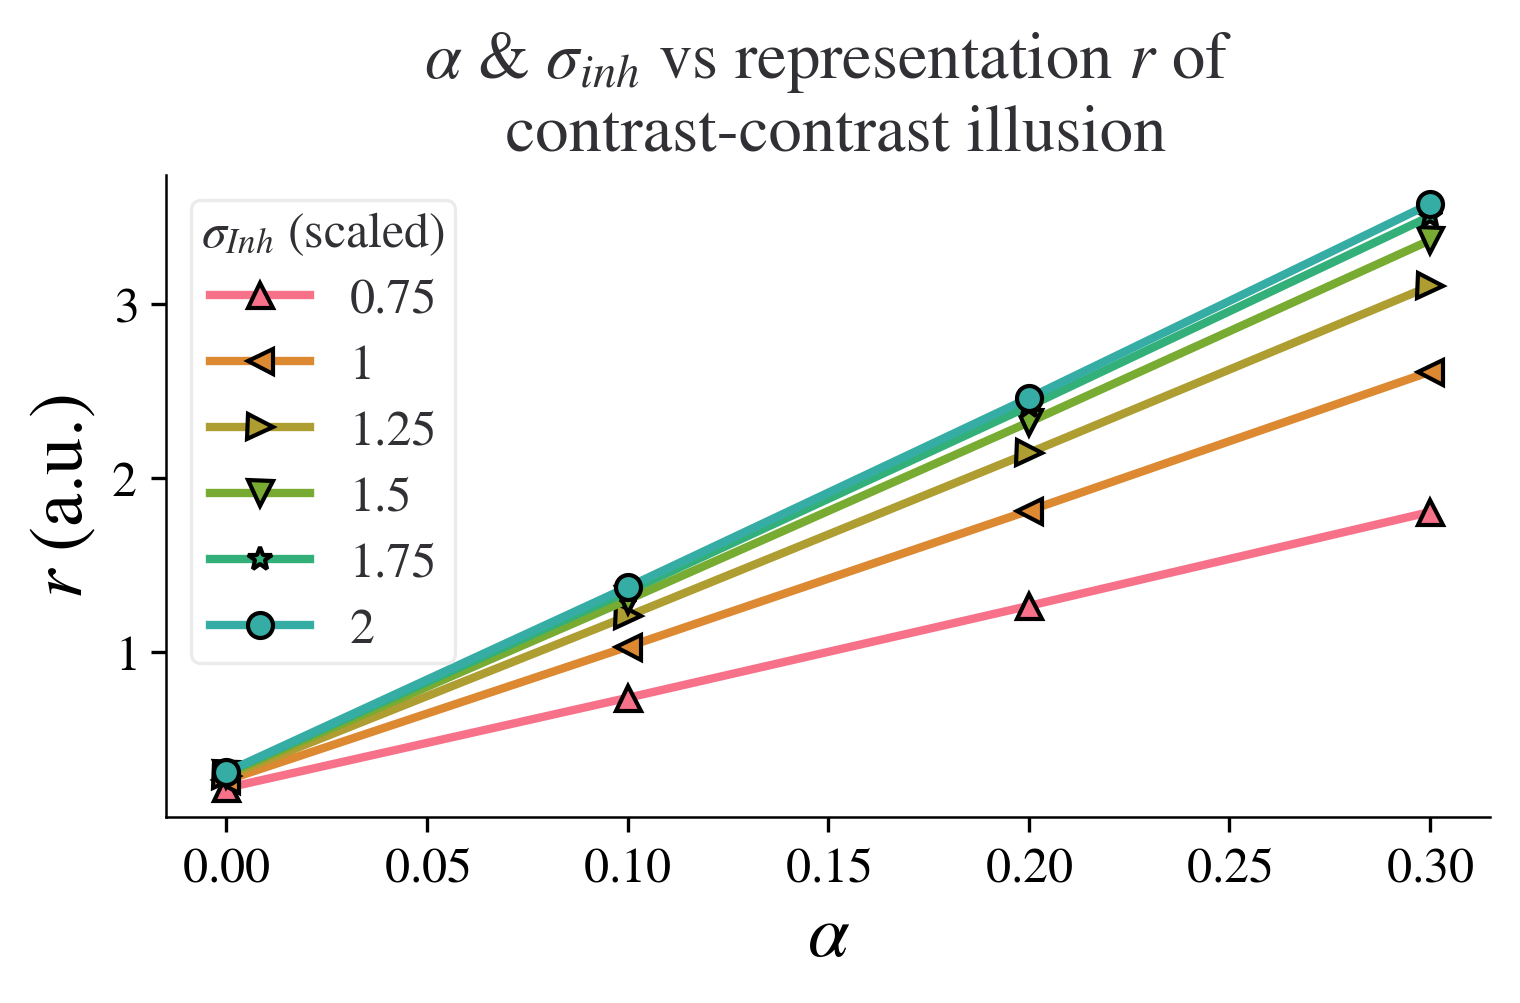

In [27]:

plt.figure(figsize=(s1, s2))

marker_list = ['^','<','>','v','*','o','+','1','2']
for i in range(len(this_inh_sig_list[2:])):                           
        plt.plot(this_alpha_list,np.array(alpha_and_inh_list)[i+2,:],label=str(this_inh_sig_list[i+2]),marker=marker_list[i])
  
    

plt.xlabel(r'$\alpha$')
plt.ylabel('$r$ (a.u.)')
plt.legend(title=r"$\sigma_{Inh}$ (scaled)", loc='upper left',fontsize=12, title_fontsize=12)#, bbox_to_anchor=(1, 0.5))

plt.title(r'$\alpha$ & $\sigma_{inh}$ vs representation $r$ of'+ '\n contrast-contrast illusion', loc='center',fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(fig_save_path , 'cc_inh_al_rep.'+'png'), dpi=300)
with open(os.path.join(fig_save_path , 'cc_inh_al_rep.pickle'),'wb') as fid:
    fig = plt.gcf()
    pickle.dump(fig, fid)